In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform

def generate_gw(m1, m2, spin1z=0, spin2z=0, f_lower=20.0, delta_t=1/4096):
    hp, hc = get_td_waveform(approximant="IMRPhenomD",
                             mass1=m1, mass2=m2,
                             spin1z=spin1z, spin2z=spin2z,
                             f_lower=f_lower, delta_t=delta_t,
                             distance=400)
    return hp.numpy()

In [3]:
# Example training grid
m1s = np.linspace(20, 40, 10)
m2s = np.linspace(20, 40, 10)

signals = []
params = []
for m1 in m1s:
    for m2 in m2s:
        h = generate_gw(m1, m2)
        # resample / pad so all signals have same length
        h = h[:4000]  # for simplicity
        signals.append(h)
        params.append([m1, m2])

S = np.column_stack(signals)  # shape (T, N)
params = np.array(params)     # shape (N, d)

In [4]:
U, s, Vt = np.linalg.svd(S, full_matrices=False)
r = 20  # pick number of basis vectors (check cumulative energy)
Ur = U[:, :r]
sr = s[:r]
Vtr = Vt[:r, :]
C_train = np.diag(sr) @ Vtr   # coefficients (r, N)

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# polynomial regression (quadratic)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(params)

models = []
for i in range(r):
    model = LinearRegression().fit(X_poly, C_train[i, :])
    models.append(model)

In [6]:
def surrogate_gw(params_star):
    # params_star = [m1, m2]
    X_star = poly.transform([params_star])
    c_pred = np.array([model.predict(X_star)[0] for model in models])
    return Ur @ c_pred  # reconstructed waveform

In [10]:
hp = surrogate_gw([25, 25])

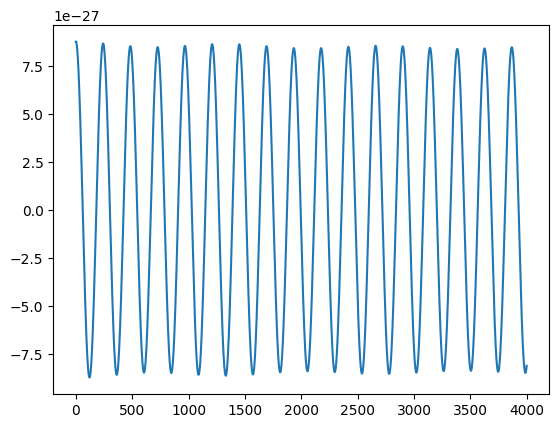

In [11]:
plt.plot(hp)

In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

In [2]:
import numpy as np
from pycbc.waveform import get_td_waveform
from scipy.fft import rfft, rfftfreq
from scipy.signal import resample
from numpy.linalg import svd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
# optionally: use scipy.interpolate for splines, or skleanr's GPR / MLP for coefficient maps

# ---------- helpers ----------
def generate_td_waveform_pycbc(m1, m2, spin1z=0.0, spin2z=0.0,
                               f_lower=20.0, delta_t=1/4096, distance=1.0,
                               approximant='IMRPhenomD'):
    hp, hc = get_td_waveform(approximant=approximant,
                             mass1=m1, mass2=m2,
                             spin1z=spin1z, spin2z=spin2z,
                             delta_t=delta_t, f_lower=f_lower,
                             distance=distance)
    # use plus polarization (hp) for simplicity
    return hp.numpy(), delta_t

def to_frequency_domain(td, delta_t, fmin=None, fmax=None, nfft=None):
    # compute rfft and frequency array
    if nfft is None:
        nfft = int(len(td))
    fd = rfft(td, n=nfft)
    freqs = rfftfreq(nfft, delta_t)
    # optionally crop to [fmin, fmax]
    if fmin is not None or fmax is not None:
        mask = np.ones_like(freqs, bool)
        if fmin is not None: mask &= (freqs >= fmin)
        if fmax is not None: mask &= (freqs <= fmax)
        return freqs[mask], fd[mask]
    return freqs, fd

def amplitude_phase_from_complex(fd):
    A = np.abs(fd)
    phi = np.angle(fd)
    # unwrap phase to avoid 2pi jumps
    phi = np.unwrap(phi)
    return A, phi

def remove_linear_phase_fit(freqs, phi):
    # fit phi ~ a * f + b, subtract linear part to remove time and phase offsets
    A = np.vstack([freqs, np.ones_like(freqs)]).T
    coeffs, *_ = np.linalg.lstsq(A, phi, rcond=None)
    linear = A @ coeffs
    phi_centered = phi - linear
    return phi_centered, coeffs  # coeffs = [a, b]

# ---------- training data generation ----------
# small demo grid (expand for real models)
m1s = np.linspace(20, 60, 10)
m2s = np.linspace(20, 60, 10)
spin_vals = [0.0]  # if you want spins add grid in spin1, spin2

f_lower = 20.0
delta_t = 1/4096
nfft = 32768  # choose large enough nfft to get desired freq resolution
fmin, fmax = f_lower, 1024.0

freq_grid_common = None
A_list = []
Phi_list = []
param_list = []

for m1 in m1s:
    for m2 in m2s:
        # generate td waveform
        td, dt = generate_td_waveform_pycbc(m1, m2, f_lower=f_lower, delta_t=delta_t)
        freqs, fd = to_frequency_domain(td, dt, nfft=nfft)
        # crop to freq band
        mask = (freqs >= fmin) & (freqs <= fmax)
        freqs = freqs[mask]; fd = fd[mask]
        A, phi = amplitude_phase_from_complex(fd)
        # remove linear phase (time & phase shifts)
        phi_centered, lin_coeffs = remove_linear_phase_fit(freqs, phi)
        # optionally: smooth low-frequency amplitude via PN fit to reduce numerical noise (see paper)
        # store
        if freq_grid_common is None:
            freq_grid_common = freqs
        else:
            # ensure same freq sampling for all (or resample/interpolate onto freq_grid_common)
            assert np.allclose(freq_grid_common, freqs)
        A_list.append(A)
        Phi_list.append(phi_centered)
        param_list.append([m1, m2])

A_mat = np.column_stack(A_list)      # shape (m, N)
Phi_mat = np.column_stack(Phi_list)  # shape (m, N)
params = np.array(param_list)        # shape (N, d)

# ---------- SVD on amplitude and phase ----------
Ua, sa, Vta = svd(A_mat, full_matrices=False)
Up, sp, Vtp = svd(Phi_mat, full_matrices=False)

# choose rank based on cumulative energy
def choose_rank(s, tol=0.999):
    energy = np.cumsum(s**2) / np.sum(s**2)
    r = np.searchsorted(energy, tol) + 1
    return r

ra = choose_rank(sa, tol=0.999)
rp = choose_rank(sp, tol=0.999)
print("rank amplitude:", ra, "rank phase:", rp)

Ua_r = Ua[:, :ra]
Sa_r = sa[:ra]
Vta_r = Vta[:ra, :]
Ca_train = np.diag(Sa_r) @ Vta_r   # (ra, N)

Up_r = Up[:, :rp]
Sp_r = sp[:rp]
Vtp_r = Vtp[:rp, :]
Cp_train = np.diag(Sp_r) @ Vtp_r   # (rp, N)

# ---------- Fit coefficient maps (params -> coefficients) ----------
# example: polynomial features + linear regression (fast). Replace with more powerful regressors if needed.
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(params)

models_a = []
for i in range(ra):
    reg = LinearRegression().fit(X_poly, Ca_train[i, :])
    models_a.append(reg)

models_p = []
for i in range(rp):
    reg = LinearRegression().fit(X_poly, Cp_train[i, :])
    models_p.append(reg)

# ---------- Surrogate evaluator ----------
def surrogate_fd(params_star):
    Xs = poly.transform([params_star])
    ca = np.array([m.predict(Xs)[0] for m in models_a])   # shape (ra,)
    cp = np.array([m.predict(Xs)[0] for m in models_p])   # shape (rp,)
    A_recon = Ua_r @ ca
    Phi_recon_centered = Up_r @ cp
    # re-add the linear phase piece? You must add back linear term chosen for this surrogate evaluation.
    # If you choose a convention (e.g., set linear term to zero), then final time/phase alignment must be handled when comparing.
    # assemble complex fd
    fd_recon = A_recon * np.exp(1j * Phi_recon_centered)
    return freq_grid_common, fd_recon

# ---------- inverse FFT back to time domain (optional) ----------
# To go back to time domain you need to embed fd_recon into the full rfft length with correct zero-padding and inverse rfft.
from scipy.fft import irfft

def surrogate_td(params_star, nfft, delta_t, fmin=20.0, fmax=1024.0):
    freqs, fd_recon = surrogate_fd(params_star)
    
    # full rfft length
    full_len = nfft // 2 + 1
    fd_full = np.zeros(full_len, dtype=complex)
    
    # find indices where surrogate frequencies sit in full freq array
    full_freqs = rfftfreq(nfft, delta_t)
    mask = (full_freqs >= fmin) & (full_freqs <= fmax)
    fd_full[mask] = fd_recon
    
    # inverse FFT to time domain
    td_recon = irfft(fd_full, n=nfft)
    t = np.arange(nfft) * delta_t
    return t, td_recon


rank amplitude: 3 rank phase: 18


In [3]:
from pycbc.waveform import get_td_waveform

def generate_true_td(m1, m2, spin1z=0, spin2z=0, f_lower=20.0, delta_t=1/4096, nfft=32768):
    hp, hc = get_td_waveform(approximant="IMRPhenomD",
                             mass1=m1, mass2=m2,
                             spin1z=spin1z, spin2z=spin2z,
                             f_lower=f_lower, delta_t=delta_t,
                             distance=400)
    h = hp.numpy()
    # pad or truncate to nfft length
    if len(h) < nfft:
        h = np.pad(h, (0, nfft - len(h)))
    else:
        h = h[:nfft]
    t = np.arange(nfft) * delta_t
    return t, h

In [4]:
t_sur, h_sur = surrogate_td([m1, m2], nfft=32768, delta_t=1/4096)

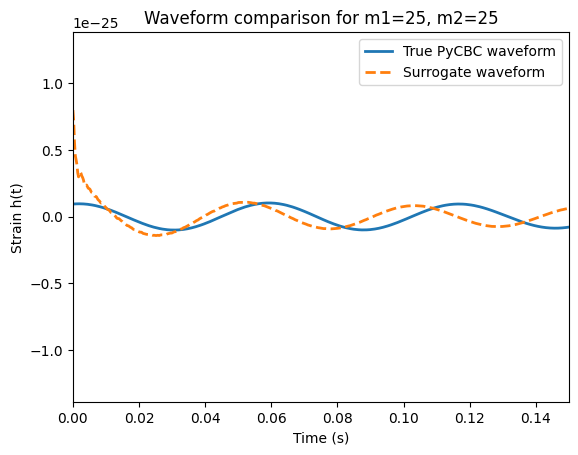

In [10]:
# pick a test parameter set
m1, m2 = 25, 25

# true waveform
t_true, h_true = generate_true_td(m1, m2, f_lower=20.0, delta_t=1/4096, nfft=32768)

# surrogate waveform
t_sur, h_sur = surrogate_td([m1, m2], nfft=32768, delta_t=1/4096)

# Plot comparison
import matplotlib.pyplot as plt
plt.figure()
plt.plot(t_true, h_true, label="True PyCBC waveform", lw=2)
plt.plot(t_sur, h_sur/1e3, "--", label="Surrogate waveform", lw=2)
plt.xlim(0, 0.15)  # zoom near merger
plt.xlabel("Time (s)")
plt.ylabel("Strain h(t)")
plt.legend()
plt.title(f"Waveform comparison for m1={m1}, m2={m2}")
plt.show()

# Surr

Step I: Generating training data...
Generated 225 valid waveforms.
Step II: Creating sparse grids and interpolating...
Step III: Performing SVD to find reduced bases...
Step IV: Interpolating projection coefficients...
Step V: Assembling the surrogate model evaluator.

Validating model with a test waveform...


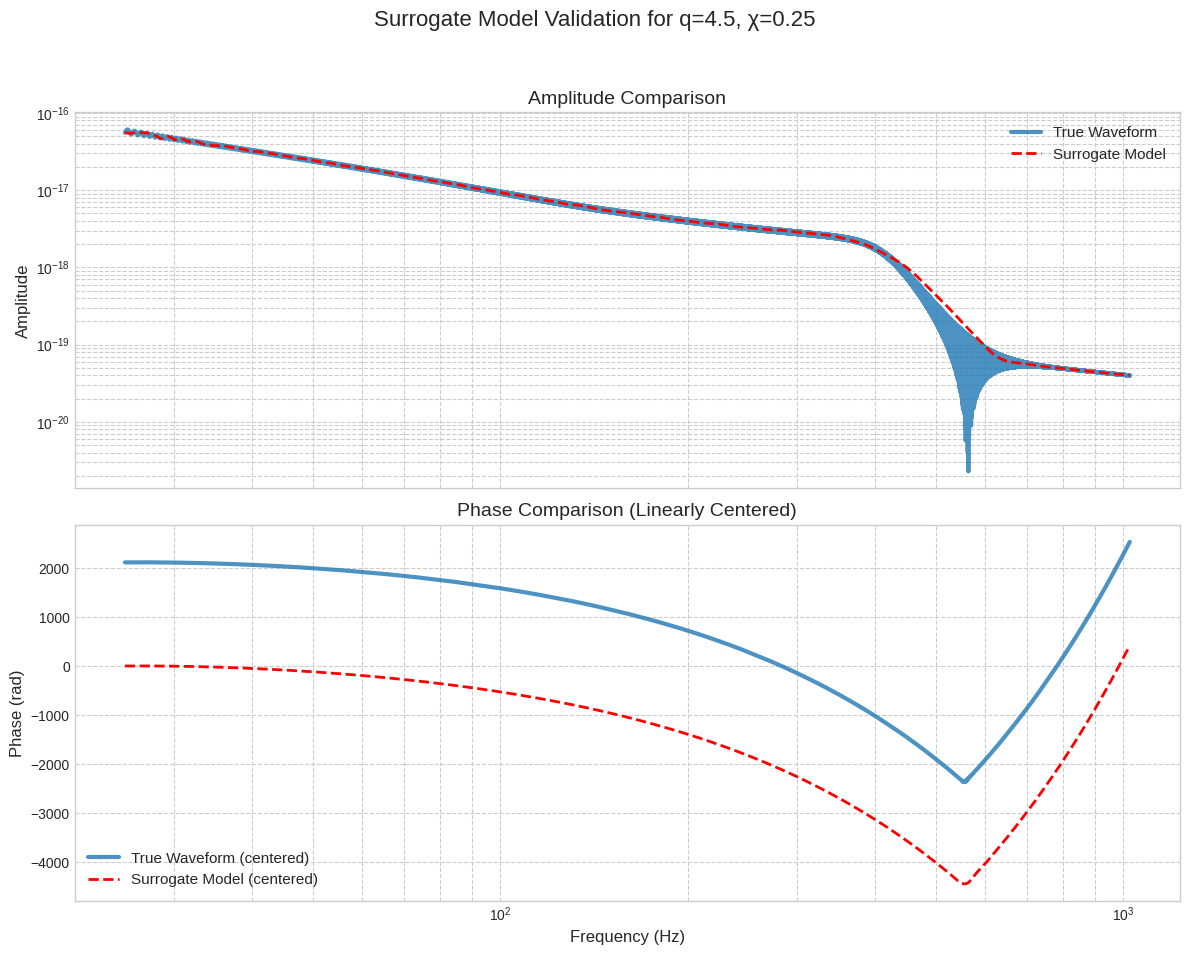

In [22]:
surr_model = surr_amp * np.exp(surr_phase*1j)

In [23]:
real_model = true_amp * np.exp(true_phase * 1j)

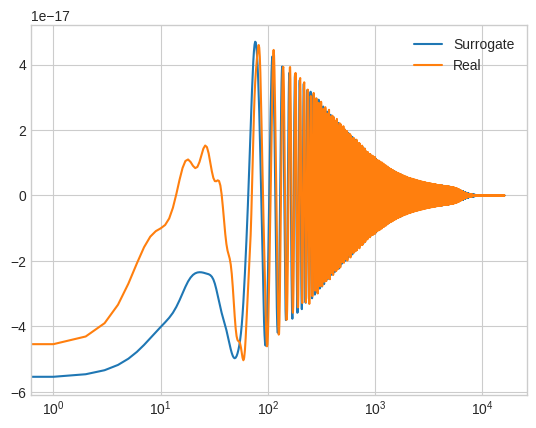

In [27]:
plt.plot(surr_model.real, label='Surrogate')
plt.plot(real_model.real, label='Real')
plt.xscale('log')
plt.legend()